In [188]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

In [3]:
data_root = Path("../data/roc_related")
miss_df_path = data_root / "raw_miss_summary.csv"
miss_df = pd.read_csv(miss_df_path)
miss_df

,filename,true,predict,0,1
0,Cursieven_rebubbled_OD_ZehReg_0017.jpg,1,1,0.487756,0.512244
1,Cursieven_rebubbled_OD_ZehReg_0020.jpg,1,1,0.486170,0.513830
2,Cursieven_rebubbled_OD_ZehReg_0019.jpg,1,1,0.489647,0.510353
3,Cursieven_rebubbled_OD_ZehReg_1008.jpg,1,1,0.489952,0.510048
4,Cursieven_rebubbled_OD_ZehReg_1010.jpg,1,1,0.486658,0.513342
...,...,...,...,...,...
615,Cursieven_nicht_rebubbled_OS_MitHei_1_000014.jpg,0,0,0.933574,0.066426
616,Cursieven_nicht_rebubbled_OS_KönDit_0_001012.jpg,0,0,0.903878,0.096122
617,Cursieven_nicht_rebubbled_OS_MitHei_0_000011.jpg,0,1,0.054317,0.945683
618,Cursieven_nicht_rebubbled_OD_BruHube_0_002002.jpg,0,0,0.877987,0.122013


In [207]:
class roc_analysis_binary():
    """
    二値分類のmiss_summary_dfからROC曲線を描き、
    Youden Indexに基づきAUC、感度、特異度の信頼区間を算出するためのクラス
    
    input
        miss_df:true, predict, 0, 1の列があるDataFrame
                true, predictの列は0/1のタグ、0, 1の列は確率値
        alpha: 有意水準、0以上1以下のfloat値        
    """
    
    def __init__(self, miss_df: pd.DataFrame, alpha: float):
        self.miss_df = miss_df.copy()
        self.alpha = alpha
        
        assert "true" in miss_df.columns
        assert "predict" in miss_df.columns
        assert "0" in miss_df.columns
        assert "1" in miss_df.columns
        assert 0 <= alpha <= 1
        
        # FPR, TPR, thresholdを計算しlistで保持
        self.fpr, self.tpr, self.thres = roc_curve(self.miss_df["true"], self.miss_df["1"])
        
        # ROC曲線のAUCと信頼区間を計算
        self.roc_auc = auc(self.fpr, self.tpr)
        self.roc_auc_ci = self.calc_roc_auc_ci()
        
        # Youden Indexに基づいた最適値(optimal thresholdとその時のFPR,TPR)を計算
        optimal_values = self.find_optimal_point(self.fpr, self.tpr, self.thres)
        self.opt_fpr, self.opt_tpr, self.opt_thres = optimal_values
        
        # 感度、特異度を計算
        self.sens = self.opt_tpr
        self.spec = 1 - self.opt_fpr
        
        # 混同行列を作成
        labels = [0,1]
        self.cross = confusion_matrix(self.miss_df["true"], self.miss_df["predict"],labels=labels)
        self.cross = pd.DataFrame(self.cross, columns=labels, index=labels)
        self.cross["All"] = [self.cross.iloc[0, 0] + self.cross.iloc[0, 1], self.cross.iloc[1, 0] + self.cross.iloc[1, 1]]
        row_all = [self.cross[0].sum(), self.cross[1].sum(), self.cross["All"].sum()]
        self.cross = pd.concat([self.cross, pd.DataFrame(row_all, index=labels+["All"]).T])
        self.cross.index = [0, 1, "All"]
        
        # 感度の信頼区間
        self.k_sens = self.cross.iloc[1, 1]
        self.n_sens = self.cross.iloc[1, 0] + self.cross.iloc[1, 1]
        self.sens_ci = proportion_confint(self.k_sens, self.n_sens, self.alpha, method="beta")
        
        # 特異度の信頼区間
        self.k_spec = self.cross.iloc[0, 0]
        self.n_spec = self.cross.iloc[0, 0] + self.cross.iloc[0, 1]
        self.spec_ci = proportion_confint(self.k_spec, self.n_spec, self.alpha, method="beta")


    # サマリー
    def summary(self):
        print("混同行列")
        display(self.cross)
        print(f"閾値\t{self.opt_thres:.3f}")
        conf_coef = round((1 - self.alpha) * 100)
        print(f"AUC\t{self.roc_auc:.3f}\t{conf_coef}％信頼区間[{self.roc_auc_ci[0]:.3f}, {self.roc_auc_ci[1]:.3f}]")
        print(f"感度\t{self.sens:.3f}\t{conf_coef}％信頼区間[{self.sens_ci[0]:.3f}, {self.sens_ci[1]:.3f}]")
        print(f"特異度\t{self.spec:.3f}\t{conf_coef}％信頼区間[{self.spec_ci[0]:.3f}, {self.spec_ci[1]:.3f}]")
        self.plot_roc_curve()


    # 計算処理系
    @staticmethod
    def find_optimal_point(fpr: list, tpr: list, thres: list):
        """
        FPR, TPR, thresholdの配列から、Youden Index最大のものをそれぞれ取得
        """
        fpr, tpr = np.array(fpr), np.array(tpr)
        idx = np.argmax(tpr - fpr)
        return fpr[idx], tpr[idx], thres[idx]
    
    def calc_roc_auc_ci(self):
        """
        ROC曲線のAUCの信頼区間を算出する
        """
        AUC = self.roc_auc
        N1 = self.miss_df["true"].sum()
        N2 = len(self.miss_df) - N1
        
        Q1 = AUC / (2 - AUC)
        Q2 = 2*AUC**2 / (1 + AUC)
        SE_AUC = np.sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + 
                            (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
        lower, upper = st.norm.interval(1-self.alpha, loc=AUC, scale=SE_AUC)
        if lower < 0:
            lower = 0
        if upper > 1:
            upper = 1
        return lower, upper

    
    # 出力系
    def output_summary_csv(self, new_folder: str ="./", new_filename: str ="summary.csv"):
        new_folder = Path(new_folder)
        new_path = new_folder / new_filename
        auc_list = [self.roc_auc, *self.roc_auc_ci]
        sens_list = [self.sens, *self.sens_ci]
        spec_list = [self.spec, *self.spec_ci]
        res_df = pd.DataFrame({"AUC": auc_list, "感度": sens_list, "特異度": spec_list})
        res_df.to_csv(new_path, index=None, encoding="shift-jis")
        
    
    def output_confusion_matrix(self, new_folder: str ="./", new_filename: str ="confusion.csv"):
        new_folder = Path(new_folder)
        new_path = new_folder / new_filename
        self.cross.to_csv(new_path, index_label="true|predict")
    
    def output_roc_curve(self, new_img_folder: str ="./",
                       new_img_filename: str ="roc.tiff", dpi: int =300):
        """
        ROC曲線のグラフ画像を出力する
        
        input
            new_img_folder: str デフォルトは同じ階層
            new_img_filename: str  デフォルトは"roc.tiff"
            dpi: int  デフォルトは300
        output
            画像ファイル
        """
        img_folder = Path(new_img_folder)
        img_path = img_folder / new_img_filename
        
        fig, ax = plt.subplots(1,1)
        ax = self.plot_roc_curve(ax)
        plt.savefig(img_path, dpi=dpi)


    # 描画系
    def plot_roc_curve(self, ax=None):
        """
        ROC曲線のグラフ画像をplotしてaxを返す
        """
        if ax is None:
            fig, ax = plt.subplots(1,1)
        
        ax.plot(self.fpr, self.tpr, linewidth=3,
                 label=f'ROC curve (area = {self.roc_auc:.3f})')
        ax.scatter([self.opt_fpr],
                    [self.opt_tpr], s=50, c="green")
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve')
        ax.legend(loc="lower right")
        ax.set_aspect("equal")
        return ax


混同行列


,0,1,All
0,218,92,310
1,36,274,310
All,254,366,620


閾値	0.510
AUC	0.905	95％信頼区間[0.880, 0.929]
感度	0.826	95％信頼区間[0.843, 0.917]
特異度	0.819	95％信頼区間[0.649, 0.754]


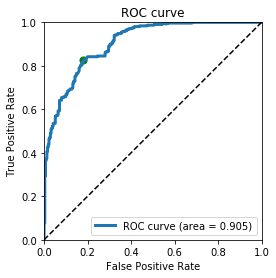

In [208]:
roc_ins = roc_analysis_binary(miss_df, 0.05)
roc_ins.summary()
roc_ins.output_summary_csv()

In [209]:
miss_df.describe()

,true,predict,0,1
count,620.000000,620.000000,620.000000,620.000000
mean,0.500000,0.590323,0.523543,0.476457
std,0.500404,0.492171,0.365608,0.365608
min,0.000000,0.000000,0.000048,0.000007
25%,0.000000,0.000000,0.145928,0.046570
50%,0.500000,1.000000,0.490318,0.509682
75%,1.000000,1.000000,0.953430,0.854072
max,1.000000,1.000000,0.999993,0.999952


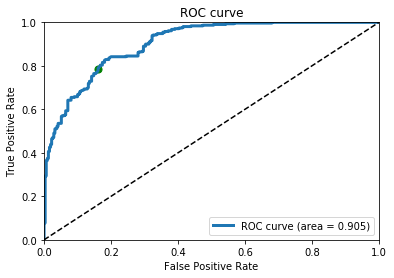

In [22]:
fpr, tpr, thres = roc_curve(miss_df["true"], miss_df["1"])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, linewidth=3,
         label='ROC curve (area = %0.3f)' % roc_auc)
n = len(fpr)//2
plt.scatter([fpr[n]],
            [tpr[n]], s=50, c="green")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(roc_fig, dpi=300)
plt.close()